### Проект: Прогнозирование выручки B2B-клиентов (Customer Revenue Prediction)

* Цель: Построить регрессионную модель для прогнозирования месячной/квартальной выручки от B2B-клиента. Это поможет бизнесу в прогнозировании, выявлении ценных клиентов и планировании ресурсов.

Подходящий датасет:
`"Online Retail II" от UCI`. Это реальные данные транзакций онлайн-ритейлера, идеально подходящие для моделирования B2B-выручки.

Ссылка: `https://archive.ics.uci.edu/ml/datasets/Online+Retail+II`

Dataset Information:
Additional Information
This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. 
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). 
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal. The name of the country where a customer resides.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
data = pd.read_excel('./online_retail_II.xlsx', )

In [10]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
data.shape

(525461, 8)

In [14]:
data.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [16]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Пропуски в колонке `Customer ID` означают, что клиенты, совершившие данные транзакции не зарегистрированы, т.е. у них нет `user lifetime`, соответственно удалим эти строки

Строки с пропусками в колонке `Description` убирать неккоректно, т.к. можно потерять важные данные, поэтому заполним пропуски значением `Unknown`

In [19]:
#резервная копия изначального датасета
begin_data = data

In [21]:
data = data.dropna(subset=['Customer ID'])

data.Description = data.Description.fillna('Unknown')

data.isnull().sum()

/var/folders/k1/hxfc7h5s1mlbns_9p76yy7240000gn/T/ipykernel_63638/3413913713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Description = data.Description.fillna('Unknown')


Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [23]:
data.shape

(417534, 8)

In [25]:
#исключим возвраты(quantity < 0) из выборки, поскольку для прогнозирования выручки они - шум
returned_orders = data[data['Quantity'] < 0]

data = data[data['Quantity'] >= 0]

### Далее найдем выбросы(Quantity, Price) и обработаем их

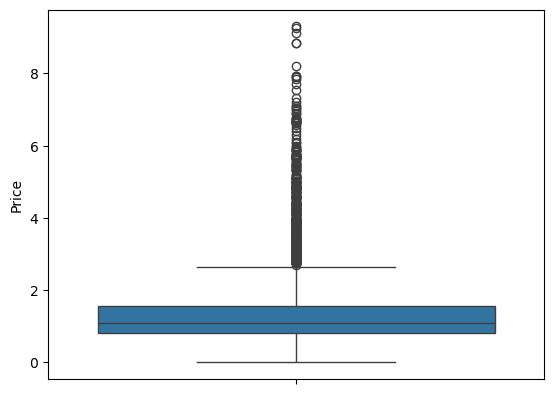

In [28]:
sns.boxplot(data=np.log1p(data['Price']))
plt.show()

In [30]:
data[np.log1p(data.Price) > 2.5].count()

Invoice        9952
StockCode      9952
Description    9952
Quantity       9952
InvoiceDate    9952
Price          9952
Customer ID    9952
Country        9952
dtype: int64

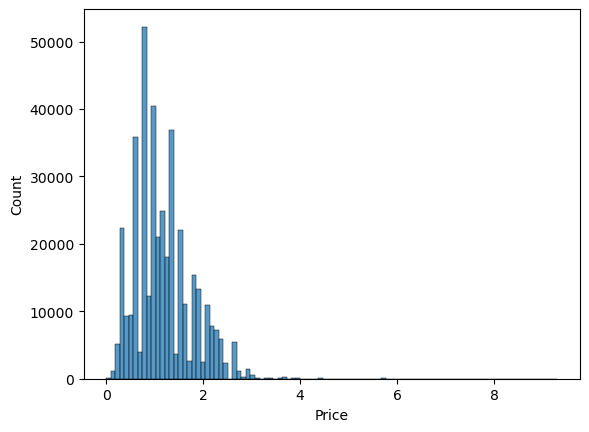

In [32]:
sns.histplot(np.log1p(data['Price']), bins=100)
plt.show()

In [34]:
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR

outliers_price = data[(data['Price'] < lower) | (data['Price'] > upper)]
outliers_price.Price

22         8.50
35         9.95
38         8.95
88         7.95
89        18.00
          ...  
525289     8.50
525290     8.50
525323    12.75
525366     7.95
525396    35.95
Name: Price, Length: 32989, dtype: float64

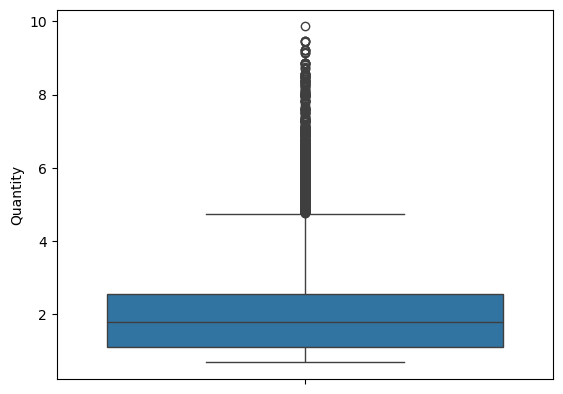

In [36]:
sns.boxplot(data=np.log1p(data['Quantity']))
plt.show()

In [38]:
data[np.log1p(data.Quantity) > 4.5].count()

Invoice        8417
StockCode      8417
Description    8417
Quantity       8417
InvoiceDate    8417
Price          8417
Customer ID    8417
Country        8417
dtype: int64

In [40]:
Q1 = data['Quantity'].quantile(0.25)
Q3 = data['Quantity'].quantile(0.75)
IQR = Q3 - Q1

upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR

outliers_price = data[(data['Quantity'] < lower) | (data['Quantity'] > upper)]
outliers_price.Quantity

3         48
54        28
55        30
56        30
57        30
          ..
525005    50
525283    72
525285    72
525303    40
525446    48
Name: Quantity, Length: 26338, dtype: int64

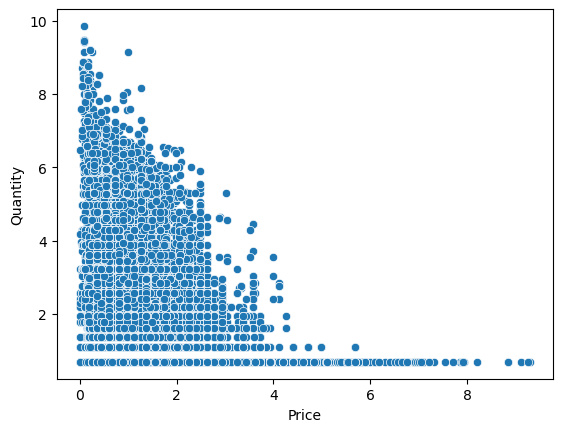

In [42]:
sns.scatterplot(x=np.log1p(data['Price']), y=np.log1p(data['Quantity']))
plt.show()

In [44]:
#удалим наблюдения с Price == 0
zero_price_samples = data[data.Price == 0]

zero_price_samples.agg({'Price': 'count'})

Price    31
dtype: int64

In [46]:
data = data[data.Price != 0.0]
data.shape

(407664, 8)

In [48]:
data[data.Price == 0].agg({'Price': 'count'})

Price    0
dtype: int64

IQR выбросы - важные наблюдения - большие и маленькие клиенты, их удалять нельзя, но можно логарифмировать значения параметров quantity, price, чтобы модель была не так чувствительна к выбросам

In [51]:
data['Price_log'] = np.log1p(data['Price'])
data['Quantity_log'] = np.log1p(data['Quantity'])
data[['Price_log', 'Quantity_log']]

,Price_log,Quantity_log
0,2.073172,2.564949
1,2.047693,2.564949
2,2.047693,2.564949
3,1.131402,3.891820
4,0.810930,3.218876
...,...,...
525456,1.373716,1.098612
525457,1.558145,0.693147
525458,1.558145,0.693147
525459,1.558145,1.098612


Cоздадим целевую переменную - итоговая выручка

In [54]:
data['TotalRevenue'] = data.Price * data.Quantity

Создадим RFM(Recency, Frequency, Monetary) признаки
-
- Recency: Количество дней с последней покупки клиента. (max(InvoiceDate) - last_purchase_date)
- Frequency: Общее количество чеков (уникальных InvoiceNo) у клиента.
- Monetary: Суммарная выручка с клиента (TotalRevenue).

In [57]:
biggest_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = data.groupby('Customer ID')\
          .agg({
              'InvoiceDate': lambda x: (biggest_date - x.max()).days,
              'Invoice': 'nunique',
              'TotalRevenue': 'sum'
              }
          )
rfm.columns = ['recency', 'frequency', 'monetary']

rfm

,recency,frequency,monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93
...,...,...,...
18283.0,18,6,641.77
18284.0,67,1,461.68
18285.0,296,1,427.00


Признаки поведения:

- `total_products_purchased`: Общее количество купленных товаров.
- `unique_products_count`: Количество уникальных купленных товаров (широта ассортимента).
- `avg_quantity_per_transaction`: Среднее количество товаров в чеке.
- `avg_basket_value`: Средний чек (Monetary / Frequency).


In [60]:
behaviour_features = data.groupby('Customer ID')\
                         .agg(
            total_products_purchased = ('Quantity', 'sum'),
            unique_products_count = ('StockCode', 'nunique'),
            avg_quantity_per_transaction = ('Quantity', 'mean')
        )


behaviour_features['avg_basket_value'] = rfm.monetary / rfm.frequency

behaviour_features

,total_products_purchased,unique_products_count,avg_quantity_per_transaction,avg_basket_value
Customer ID,,,,
12346.0,70,26,2.121212,33.896364
12347.0,828,70,11.661972,661.660000
12348.0,373,20,18.650000,222.160000
12349.0,993,90,9.735294,890.380000
12351.0,261,21,12.428571,300.930000
...,...,...,...,...
18283.0,336,158,1.460870,106.961667
18284.0,494,28,17.642857,461.680000
18285.0,145,12,12.083333,427.000000


In [62]:
trans_details_features = data.groupby('Customer ID')\
                             .agg(
                                 country_diversity = ('Country', 'nunique')
                             )
trans_details_features        

,country_diversity
Customer ID,
12346.0,1
12347.0,1
12348.0,1
12349.0,1
12351.0,1
...,...
18283.0,1
18284.0,1
18285.0,1


Признаки из деталей транзакций:

- `cancellation_rate`: Доля транзакций, которые были отменены.
- `country_diversity`: Количество уникальных стран, в которые клиент делал заказы (если применимо).

In [92]:
trans_details_features = data.groupby('Customer ID')\
                             .agg(
                                 country_diversity = ('Country', 'nunique')
                             )
trans_details_features['cancellation_rate'] = (
    begin_data['Invoice']
    .astype(str)
    .str.startswith('C')
    .groupby(begin_data['Customer ID'])
    .mean()
)

In [94]:
trans_details_features

,country_diversity,cancellation_rate
Customer ID,,
12346.0,1,0.282609
12347.0,1,0.000000
12348.0,1,0.000000
12349.0,1,0.046729
12351.0,1,0.000000
...,...,...
18283.0,1,0.000000
18284.0,1,0.034483
18285.0,1,0.000000


Признаки на основе временных рядов (агрегация по периодам):
Создадим отдельные датасеты с агрегатами за последние 3, 6, 12 месяцев и рассчитаем те же признаки, что и выше, но для этих окон. Это покажет динамику поведения клиента.

- `revenue_last_3m`, `frequency_last_3m`, `avg_basket_last_3m`
- `revenue_growth_3m_vs_6m`: Рост выручки за последние 3 месяца по сравнению с предыдущими 3.
Временные признаки из даты:

- `customer_tenure`: "Возраст" клиента (дни с первой покупки).
- `is_weekend_buyer`: Доля покупок, совершенных на выходных.
- `preferred_hour`: Самый популярный час для покупок.